# Regression Modeling for Player Prediction #

Models: 
1. Career length (number of seasons played)
2. Career or player prime VORP, plus-minus, win-shares, etc. 

Steps:
1. Normalize data (or data comes pre-normalized)
2. Possibly perform PCA (principal component analysis)
3. For each model, run feature selection to determine the k-best features <br>
  a. Training data will be from past players who have already retired <br>
          <emsp> Input: early career stats <br>
          <emsp> Output: career projections <br>
  b. Testing data can be current players 
4. For each model, use randomized grid search with k-fold cross validation to
   build a linear regression model 

In [30]:
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn import svm 


In [31]:
# import data 
raw_data = pd.read_csv('formatted_training_data.csv')
# keep only retired players
training_data = raw_data.loc[raw_data['Retired'] == 1]
# remove players who only played one season
training_data = training_data.loc[training_data['Guard2'] < 2]
# remove names and player ids
training_data = training_data.drop(['urlID', 'Name', 'Retired'], axis=1)
# replace undrafted players with empty values
training_data = training_data.replace(to_replace =["Undrafted"], 
                                      value = np.nan)

tr_data = training_data.to_numpy()
                       
imputer = KNNImputer(n_neighbors=5, weights="uniform")
tr_data = imputer.fit_transform(tr_data)

tr_df = pd.DataFrame(tr_data, columns=['Career_length', 'Career_WS/48', 'Career_OBPM', 'Career_DBPM',
       'Career_BPM', 'Career_VORP', 'Draft_pick', 'Undrafted',
       'Rookie_age', 'Guard1', 'Forward1', 'Center1', 'G1', 'MP1', 'PER1',
       'TS1', '3PAr1', 'FTr1', 'ORB%1', 'DRB%1', 'TRB%1', 'AST%1', 'STL%1',
       'BLK%1', 'TOV%1', 'USG%1', 'OWS1', 'DWS1', 'WS1', 'WS/48_1', 'OBPM1',
       'DBPM1', 'BPM1', 'VORP1', 'Guard2', 'Forward2', 'Center2', 'G2', 'MP2',
       'PER2', 'TS2', '3PAr2', 'FTr2', 'ORB%2', 'DRB%2', 'TRB%2', 'AST%2',
       'STL%2', 'BLK%2', 'TOV%2', 'USG%2', 'OWS2', 'DWS2', 'WS2', 'WS/48_2',
       'OBPM2', 'DBPM2', 'BPM2', 'VORP2'])

x_test_df = tr_df.drop(['Career_length', 'Career_WS/48', 'Career_OBPM', 'Career_DBPM',
                         'Career_BPM', 'Career_VORP'], axis=1)

tr_df

,Career_length,Career_WS/48,Career_OBPM,Career_DBPM,Career_BPM,Career_VORP,Draft_pick,Undrafted,Rookie_age,Guard1,...,TOV%2,USG%2,OWS2,DWS2,WS2,WS/48_2,OBPM2,DBPM2,BPM2,VORP2
0,9.0,0.061000,-2.911111,0.122222,-2.766667,-0.100000,6.0,0.0,22.0,0.0,...,17.3,20.3,1.4,3.6,4.9,0.094,-1.3,1.2,-0.1,1.2
1,4.0,0.097000,0.925000,-2.475000,-1.600000,0.025000,47.0,0.0,23.0,1.0,...,13.1,28.9,2.4,1.2,3.6,0.111,1.9,-2.5,-0.7,0.5
2,13.0,0.195154,4.276923,2.307692,6.592308,6.123077,6.0,0.0,23.0,0.0,...,14.9,24.3,4.7,6.1,10.8,0.160,2.1,3.0,5.1,5.8
3,9.0,0.069889,-1.844444,1.933333,0.088889,0.733333,13.0,0.0,22.0,1.0,...,16.1,16.3,1.0,2.9,3.9,0.100,-0.4,2.3,1.9,1.8
4,15.0,0.105333,-1.293333,-0.040000,-1.333333,0.713333,3.0,0.0,22.0,0.0,...,12.9,21.5,6.9,3.1,10.0,0.164,1.2,-0.7,0.5,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,2.0,-0.063500,-6.450000,-1.350000,-7.800000,-0.050000,43.8,1.0,22.0,1.0,...,34.0,20.0,0.0,0.0,0.0,-0.083,-8.9,-1.9,-10.8,0.0
1584,2.0,-0.000500,-4.650000,-1.300000,-5.950000,-0.550000,21.4,1.0,22.0,1.0,...,15.7,20.1,0.2,0.5,0.6,0.027,-2.9,-2.5,-5.4,-1.0
1585,2.0,0.044000,-1.400000,-0.200000,-1.600000,0.300000,14.0,0.0,23.0,1.0,...,11.8,17.5,1.0,1.5,2.5,0.057,-0.4,-0.1,-0.5,0.8
1586,2.0,-0.029000,-4.300000,-0.950000,-5.250000,-0.700000,42.0,0.0,21.0,1.0,...,20.3,28.5,-0.3,0.2,-0.1,-0.035,-4.3,-1.3,-5.6,-0.2


In [32]:
def makeModel(data, y_name, is_ridge):
    # separate x and y sets based on the name of the param to estimate
    y_train = data[y_name].to_numpy()
    x_train = data.drop(['Career_length', 'Career_WS/48', 'Career_OBPM', 'Career_DBPM',
                         'Career_BPM', 'Career_VORP'], axis=1).to_numpy()

    # params for searching 
    param_grid = {
        "pca__n_components": np.arange(start=7, stop=30, step=3),
        "polynomialfeatures__degree": np.arange(start=1, stop=3, step=1),
    }
    
    search = None

    # pipeline for regression
    if is_ridge:
        pipe = make_pipeline(MinMaxScaler(),
                            PCA(),
                            PolynomialFeatures(), 
                            Ridge())
        search = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', return_train_score=True)
    else:
        pipe = make_pipeline(MinMaxScaler(),
                            PCA(),
                            PolynomialFeatures(), 
                            svm.SVR())
        search = GridSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error', return_train_score=True)
        
    search.fit(x_train, y_train)

    return search, search.best_score_


In [33]:
to_predict = ['Career_length', 'Career_WS/48', 'Career_OBPM', 'Career_DBPM',
                         'Career_BPM', 'Career_VORP']
models = []
rms = []
is_ridge = [True, True, False, True, False, False]

for y, ir in zip(to_predict, is_ridge):
    m, score = makeModel(tr_df, y, ir)
    models.append(m)
    rms.append(score)



In [34]:
# model export using Pickle 
import pickle

model_names = ['Career_length', 'Career_WS_48', 'Career_OBPM', 'Career_DBPM',
                         'Career_BPM', 'Career_VORP']

for m, name in zip(models, model_names):
    filename = name + '.pkl'
    pickle.dump(m, open(filename,'wb'))


In [35]:

# x_test = x_test_df.iloc[3].to_numpy().reshape(1, -1)

# cols = ['Career_length', 'Career_WS/48', 'Career_OBPM', 'Career_DBPM',
#                          'Career_BPM', 'Career_VORP']

# pred = models[0].predict(x_test_df.to_numpy())
# act = training_data['Career_length']

# diff = pred - act 
# for m in models:
#     print(m.best_params_)
# rms



In [53]:
from sklearn.cluster import KMeans

pred_cl = models[0].predict(x_test_df.to_numpy())
pred_obpm = models[2].predict(x_test_df.to_numpy())
pred_dbpm = models[3].predict(x_test_df.to_numpy())

cluster_x_tr = np.array([pred_cl, pred_obpm, pred_dbpm]).transpose()


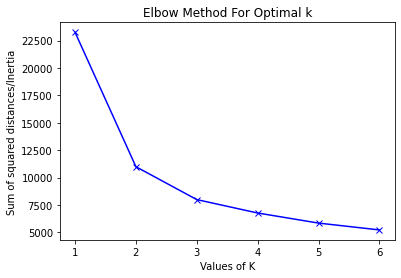

In [57]:
import matplotlib.pyplot as plt

def genClf (data):

    num_k = np.arange(start=1, stop=7, step=1)
    clusters = []
    sum_of_squared_distances = []
    
    for k in num_k:
        pipe = make_pipeline(MinMaxScaler(), 
                             KMeans(init='k-means++', n_clusters=k))
        cl = KMeans(init='k-means++', n_clusters=k).fit(data)
        sum_of_squared_distances.append(cl.inertia_)
        clusters.append(cl)

    plt.plot(num_k, sum_of_squared_distances,'bx-')
    plt.xlabel('Values of K') 
    plt.ylabel('Sum of squared distances/Inertia') 
    plt.title('Elbow Method For Optimal k')
    plt.show()

    return clusters[2] # k = 4


km_cl = genClf(cluster_x_tr)


In [58]:
# km_cl.predict(np.array([10, 1, -1]).reshape(1, -1))
km_cl.cluster_centers_


array([[ 7.59031817, -2.22380404, -0.67543245],
       [11.32904853, -0.39018319,  0.12359182],
       [ 4.165553  , -3.99502919, -1.39566674]])